# visualize graph as array

In [2]:
import re
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Set, Tuple, Optional, Dict, Iterable, Union

import numpy as np
import matplotlib.pyplot as plt

In [7]:
"""
Build a rectangular binary grid from a yEd GraphML by reading node labels like "r,c",
then plot it as a map where 1 marks a node cell.

Coordinate convention (YOUR request):
- The FIRST number in the label is the ROW (vertical axis).
- The SECOND number in the label is the COLUMN (horizontal axis).
- So label "2,30" means row=2, col=30.

Rows increase downward in the plot (origin='upper'), matching typical image coordinates.
"""

import re
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Set, Tuple, Optional, Dict, Iterable, Union

import numpy as np
import matplotlib.pyplot as plt

# yEd / GraphML namespaces
NS = {
    "g": "http://graphml.graphdrawing.org/xmlns",
    "y": "http://www.yworks.com/xml/graphml",
}

LABEL_RE = re.compile(r"^\s*(-?\d+)\s*,\s*(-?\d+)\s*$")

def extract_coords_from_graphml(graphml_path: Union[str, Path]) -> Set[Tuple[int, int]]:
    """
    Parse a yEd GraphML and return the set of integer coordinates (row, col)
    taken from each node's y:NodeLabel text "row,col".
    Ignores nodes whose labels are missing or not parseable.
    """
    tree = ET.parse(str(graphml_path))
    root = tree.getroot()

    coords: Set[Tuple[int, int]] = set()

    # Walk all nodes; support ShapeNode and GenericNode
    for n in root.findall(".//g:graph/g:node", NS):
        txt: Optional[str] = None
        for d in n.findall("./g:data", NS):
            # yEd commonly puts labels under ShapeNode; GenericNode as fallback
            lab = d.find("./y:ShapeNode/y:NodeLabel", NS)
            if lab is None:
                lab = d.find("./y:GenericNode/y:NodeLabel", NS)
            if lab is not None and lab.text:
                txt = lab.text.strip()
                break

        if not txt:
            continue

        m = LABEL_RE.match(txt)
        if not m:
            continue

        row = int(m.group(1))  # FIRST number = ROW  (vertical)
        col = int(m.group(2))  # SECOND number = COL (horizontal)
        coords.add((row, col))

    if not coords:
        raise RuntimeError("No parseable node labels of the form 'row,col' were found in the GraphML.")

    return coords


def build_binary_grid(
    coords: Iterable[Tuple[int, int]],
    *,
    min_row: Optional[int] = None,
    max_row: Optional[int] = None,
    min_col: Optional[int] = None,
    max_col: Optional[int] = None,
    pad: int = 0,
    dtype=np.uint8,
) -> Tuple[np.ndarray, Dict[str, int]]:
    """
    Create a binary grid where 1 marks a node at coordinate (row, col).

    Grid layout:
      - rows correspond to ROW (vertical), columns to COL (horizontal)
      - origin at top-left (row 0, col 0) represents (row=min_row, col=min_col)
      - grid shape = (max_row - min_row + 1 + 2*pad, max_col - min_col + 1 + 2*pad)

    Returns:
      grid (H x W) and a dict with bounds: {min_row, max_row, min_col, max_col, pad}
    """
    coords = set(coords)
    if not coords:
        raise ValueError("No coordinates provided.")

    row_vals = [r for r, _ in coords]
    col_vals = [c for _, c in coords]

    if min_row is None: min_row = min(row_vals)
    if max_row is None: max_row = max(row_vals)
    if min_col is None: min_col = min(col_vals)
    if max_col is None: max_col = max(col_vals)

    height = (max_row - min_row + 1) + 2 * pad
    width  = (max_col - min_col + 1) + 2 * pad

    grid = np.zeros((height, width), dtype=dtype)

    # Place ones
    for (row, col) in coords:
        r = (row - min_row) + pad  # row index (vertical)
        c = (col - min_col) + pad  # col index (horizontal)
        if 0 <= r < height and 0 <= c < width:
            grid[r, c] = 1

    info = dict(min_row=min_row, max_row=max_row, min_col=min_col, max_col=max_col, pad=pad)
    return grid, info


def plot_binary_grid(
    grid: np.ndarray,
    info: Dict[str, int],
    *,
    figsize=(8, 8),
    annotate: bool = False,
    tick_step: Optional[int] = None,
    title: Optional[str] = None,
) -> None:
    """
    Plot the binary grid as a map (origin upper-left). By default, 1-cells appear dark.

    Parameters:
      - annotate: write the (row,col) coordinate on each 1-cell
      - tick_step: set major tick step in data coordinates (None = automatic)
      - title: optional plot title
    """
    min_row = info["min_row"]; min_col = info["min_col"]; pad = info["pad"]
    H, W = grid.shape

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(grid, origin="upper", interpolation="nearest", cmap="binary")  # 1=dark, 0=light

    # Build axis ticks in data (row,col) coordinates
    if tick_step is None:
        # choose a reasonable step based on span
        step_col = max(1, int(round(W / 16)))
        step_row = max(1, int(round(H / 16)))
    else:
        step_col = step_row = tick_step

    x_ticks = list(range(0, W, step_col))
    y_ticks = list(range(0, H, step_row))
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels([str(min_col + x - pad) for x in x_ticks])  # columns → horizontal labels
    ax.set_yticklabels([str(min_row + y - pad) for y in y_ticks])  # rows    → vertical labels
    ax.set_xlabel("column (horizontal)")
    ax.set_ylabel("row (vertical)")

    # Optional annotation: write (row,col) on 1-cells
    if annotate:
        for r in range(H):
            for c in range(W):
                if grid[r, c] == 1:
                    row = (r - pad) + min_row
                    col = (c - pad) + min_col
                    ax.text(c, r, f"{row},{col}", ha="center", va="center", fontsize=8)

    if title:
        ax.set_title(title)

    ax.grid(False)
    fig.tight_layout()
    # plt.show()  # call in your script/notebook


Number of nodes: 719
Sample coords: [(15, 21), (18, 17), (7, 17), (15, 30), (26, 30), (18, 26), (7, 26), (27, 4), (18, 35), (7, 35)]
Grid shape: (33, 42)
Bounds: {'min_row': 1, 'max_row': 31, 'min_col': 0, 'max_col': 39, 'pad': 1}


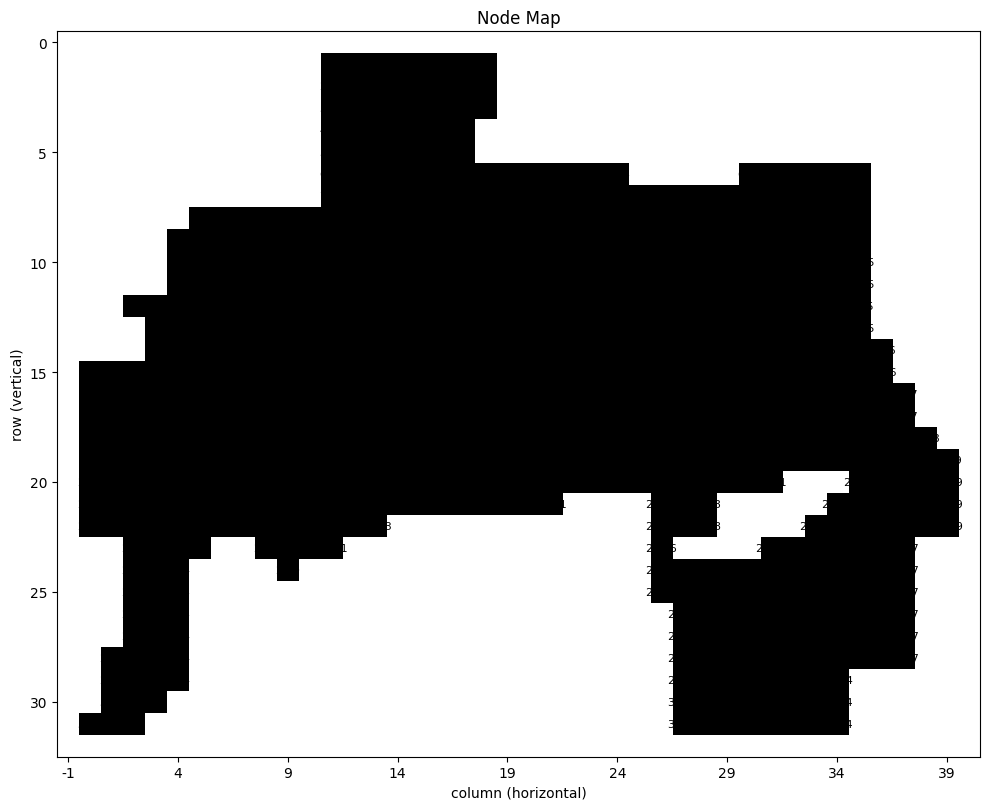

In [ ]:
coords = extract_coords_from_graphml("../mapGraphs/graphml/HIMCM_graph_final_addWeight.graphml")
print("Number of nodes:", len(coords))
print("Sample coords:", list(coords)[:10])

# 2. Build binary grid (pad=1 adds a one-cell border)
grid, info = build_binary_grid(coords, pad=1)
print("Grid shape:", grid.shape)
print("Bounds:", info)

# 3. Plot as a map
plot_binary_grid(
    grid, info,
    figsize=(10, 10),
    annotate=False,        # write (i,j) on the cells with nodes
    tick_step=5,          # put axis ticks every 5 units
    title="Node Map"
)

import matplotlib.pyplot as plt
plt.show()
